In [ ]:
import json
# Define directory where JSON files are stored
directory = 'anonymous_path/mistraljson_oneshot'
model_name = 'mistral_hellaswag' 

# Performance

In [ ]:
#new folder version
import pickle
methods = ['embedding', 'nota', 'reflect', 'token', 'moreinfo','calibration']
variants = ['','_blank_space_0','_blank_space_1', '_blank_space_2',  '_shuffled_option_0','_shuffled_option_1','_shuffled_option_2', '_typo_0',  '_typo_1','_typo_2']
for method in methods:
# Load the object from the file
#{model_name}_mmlu_{variant}
    print("method", method)
    for variant in variants:
    
    #for i in range(1,5):
        with open(f"anonymous_path/pickle_result/{method}_{model_name}{variant}_setup_0_result.pkl", "rb") as file:  # Use "rb" mode for reading binary
            loaded_data = pickle.load(file)
            #print(loaded_data.keys())
        #print("Method:", method, "index", "Variant: " ,variant)

        print(loaded_data['abstain_rate'])
        #loaded_data['reliable_accuracy'],",",loaded_data['effective_reliability'],",",loaded_data['abstain_accuracy'],",",loaded_data['abstain_precision'],",",loaded_data['abstain_recall'],",",


method embedding
0.987
0.988
0.987
0.964
0.536
0.727
0.969
0.903
0.978
0.955
method nota
0.068
0.074
0.057
0.071
0.06
0.062
0.063
0.066
0.067
0.062
method reflect
0.442
0.444
0.449
0.443
0.428
0.437
0.457
0.444
0.448
0.459
method token
0.541
0.555
0.563
0.566
0.575
0.551
0.539
0.573
0.57
0.553
method moreinfo
0.064
0.056
0.06
0.061
0.069
0.071
0.058
0.055
0.058
0.062
method calibration
0.994
0.812
0.778
0.993
0.776
0.79
0.803
0.811
0.999
0.793


In [ ]:
import pickle
methods = ['nota', 'reflect', 'token', 'moreinfo','calibration']#'embedding', 
variants = ['_typo_0', '_blank_space_0', '_shuffled_option_0','_typo_1', '_blank_space_1', '_shuffled_option_1','']
for method in methods:
    print("Method:", method)
# Load the object from the file
    #for i in range(1,5):
    for variant in variants:
        with open(f"anonymous_path/pickle_result/{method}_mistral_hellaswag{variant}_setup_0_result.pkl", "rb") as file:  # Use "rb" mode for reading binary
            loaded_data = pickle.load(file)
        print("Method:", method, "Variant: " ,variant)

        print(loaded_data['reliable_accuracy'],",",loaded_data['effective_reliability'],",",loaded_data['abstain_accuracy'],",",loaded_data['abstain_precision'],",",loaded_data['abstain_recall'],",",loaded_data['abstain_recall'])


Method: nota
Method: nota Variant:  _typo_0
0.37044967880085655 , -0.242 , 0.394 , 0.7272727272727273 , 0.07547169811320754 , 0.07547169811320754
Method: nota Variant:  _blank_space_0
0.37688984881209503 , -0.228 , 0.406 , 0.7702702702702703 , 0.08990536277602523 , 0.08990536277602523
Method: nota Variant:  _shuffled_option_0
0.35638297872340424 , -0.27 , 0.376 , 0.6833333333333333 , 0.06346749226006192 , 0.06346749226006192
Method: nota Variant:  _typo_1
0.3654876741693462 , -0.251 , 0.391 , 0.746268656716418 , 0.0778816199376947 , 0.0778816199376947
Method: nota Variant:  _blank_space_1
0.37645811240721105 , -0.233 , 0.392 , 0.6491228070175439 , 0.0592 , 0.0592
Method: nota Variant:  _shuffled_option_1
0.36673773987206826 , -0.25 , 0.392 , 0.7741935483870968 , 0.07476635514018691 , 0.07476635514018691
Method: nota Variant:  
0.37660944206008584 , -0.23 , 0.4 , 0.7205882352941176 , 0.07777777777777778 , 0.07777777777777778
Method: reflect
Method: reflect Variant:  _typo_0
0.3651079136

In [51]:
# List of methods
methods = ['embedding', 'nota', 'reflect', 'token', 'moreinfo','calibration']
variants = ['typo', 'blank_space', 'shuffled_option','original']
# Function to calculate accuracy when abstain is 0 and overall accuracy
def calculate_accuracy(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    total_count_abstain_0 = 0  # Total number of examples where abstain is 0
    correct_count_abstain_0 = 0  # Correct predictions where abstain is 0
    total_count_abstain_all = 0  # Total number of examples
    correct_count_abstain_all = 0  # Correct predictions in all cases (abstain=0 or 1)

    # Iterate over the entries in the JSON file
    for entry in data:
        decision = entry['decision']
        prediction = entry['prediction']
        gold_answer = entry['gold_answer']

        # Correct prediction is when prediction is 1 (assuming that 1 means correct)
        is_correct = 1 if prediction == gold_answer else 0

        # Count for all predictions (both abstain=0 and abstain=1)
        total_count_abstain_all += 1
        if is_correct == 1:
            correct_count_abstain_all += 1

        # Only count for abstain=0 (i.e., when the model answers)
        if decision == 0:  # Abstain flag is 0,"answer"
            total_count_abstain_0 += 1
            if is_correct == 1:
                correct_count_abstain_0 += 1

    # Calculate accuracy for abstain=0
    accuracy_abstain_0 = correct_count_abstain_0 / total_count_abstain_0 if total_count_abstain_0 > 0 else 0

    # Calculate overall accuracy (all cases)
    accuracy_abstain_all = correct_count_abstain_all / total_count_abstain_all if total_count_abstain_all > 0 else 0

    return accuracy_abstain_0, accuracy_abstain_all

# Loop over each method and each setup to calculate the accuracy
for method in methods:
    for variant in variants:
        for i in range(1):  # Assuming there are 5 setups (0 to 4)
            json_file_path = f'{directory}/{method}_{model_name}_{variant}_setup_{i}.json'

            # Calculate accuracy for this setup
            accuracy_abstain_0, accuracy_abstain_all = calculate_accuracy(json_file_path)

            # Print the results for this setup
            print(f'Method: {method}, Variant: {variant}, Setup: {i}')
            print(f'  Accuracy (abstain=0): {accuracy_abstain_0:.4f}')
            print(f'  Overall Accuracy: {accuracy_abstain_all:.4f}')
            print('-' * 50)

Method: embedding, Variant: typo, Setup: 0
  Accuracy (abstain=0): 0.6667
  Overall Accuracy: 0.4840
--------------------------------------------------
Method: embedding, Variant: blank_space, Setup: 0
  Accuracy (abstain=0): 0.6754
  Overall Accuracy: 0.4860
--------------------------------------------------
Method: embedding, Variant: shuffled_option, Setup: 0
  Accuracy (abstain=0): 0.7122
  Overall Accuracy: 0.4770
--------------------------------------------------
Method: embedding, Variant: original, Setup: 0
  Accuracy (abstain=0): 0.6405
  Overall Accuracy: 0.5060
--------------------------------------------------
Method: nota, Variant: typo, Setup: 0
  Accuracy (abstain=0): 0.4759
  Overall Accuracy: 0.4757
--------------------------------------------------
Method: nota, Variant: blank_space, Setup: 0
  Accuracy (abstain=0): 0.4968
  Overall Accuracy: 0.4818
--------------------------------------------------
Method: nota, Variant: shuffled_option, Setup: 0
  Accuracy (abstain=

# Intra-method

# Consistency Metrics

In [ ]:
import os
import json
from collections import defaultdict
from itertools import combinations
import re
import statistics

# Initialize data containers
rejections = defaultdict(set)
acceptances = defaultdict(set)
predictions = defaultdict(lambda: defaultdict(int))
total_questions_per_setup = defaultdict(int)

# Define utility functions
def calculate_iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def harmonic_mean(iou1, iou2):
    return (2 * iou1 * iou2) / (iou1 + iou2) if (iou1 + iou2) > 0 else 0

def calculate_agreement(set1, set2, predictions1, predictions2):
    common_questions = set1.intersection(set2)
    same_predictions = sum(
        predictions1[q] == predictions2[q] for q in common_questions
    )
    total_questions = len(common_questions)
    return same_predictions / total_questions if total_questions > 0 else 0

def calculate_common_accept_accuracy(set1, set2, predictions1, predictions2):
    common_questions = set1.intersection(set2)
    correct_predictions = sum(
        (predictions1[q] + predictions2[q]) / 2 for q in common_questions
    )
    total_questions = len(common_questions)
    return correct_predictions / total_questions if total_questions > 0 else 0

def calculate_rejection_rate(rejections, total_questions):
    return len(rejections) / total_questions if total_questions > 0 else 0

# JSON file processor
def process_json_file(file_path, eval_index):
    with open(file_path, 'r') as file:
        data = json.load(file)
        total_questions = len(data)
        total_questions_per_setup[eval_index] = total_questions

        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']
            prediction = entry['prediction']
            gold_answer = entry['gold_answer']

            if decision == 1:
                rejections[eval_index].add(question_idx)
            elif decision == 0:
                acceptances[eval_index].add(question_idx)
                predictions[eval_index][question_idx] = int(prediction == gold_answer)

# Process method and variant groups
def process_json_files_for_method_variant(directory, model_name, method, variant_folders, group_name):
    # Clear previous data
    rejections.clear()
    acceptances.clear()
    predictions.clear()
    total_questions_per_setup.clear()

    # Read files
    for variant_folder in variant_folders:
        variant_path = os.path.join(directory, variant_folder)
        if not os.path.isdir(variant_path):
            print(f"Warning: Directory {variant_path} does not exist. Skipping...")
            continue

        for filename in os.listdir(variant_path):
            if model_name in filename and method in filename and filename.endswith('.json'):
                file_path = os.path.join(variant_path, filename)
                match = re.search(r"mmlu_(.*?)_setup", filename)
                if match:
                    eval_index = match.group(1)
                process_json_file(file_path, eval_index)

    # Calculate metrics
    setup_indices = list(total_questions_per_setup.keys())
    harmonic_means, agreements, common_accept_accuracies = [], [], []
    rejection_ious, acceptance_ious = [], []
    rejection_rates = []

    for i, j in combinations(setup_indices, 2):
        if i in rejections and j in rejections and i in acceptances and j in acceptances and i[1] == j[1]:
            rejection_iou = calculate_iou(rejections[i], rejections[j])
            rejection_ious.append(rejection_iou)

            acceptance_iou = calculate_iou(acceptances[i], acceptances[j])
            acceptance_ious.append(acceptance_iou)
            print("acceptance", i, j, acceptance_iou)

            hm = harmonic_mean(rejection_iou, acceptance_iou)
            harmonic_means.append(hm)
            print(i,j,hm)

            agreement = calculate_agreement(acceptances[i], acceptances[j], predictions[i], predictions[j])
            agreements.append(agreement)
            print("agreement", i, j, agreement)

            common_accept_accuracy = calculate_common_accept_accuracy(acceptances[i], acceptances[j], predictions[i], predictions[j])
            common_accept_accuracies.append(common_accept_accuracy)

    for idx in setup_indices:
        rejection_rate = calculate_rejection_rate(rejections[idx], total_questions_per_setup[idx])
        rejection_rates.append(rejection_rate)

    # Calculate and display mean and stddev
    metrics = {
        "Harmonic Mean": harmonic_means,
        "Rejection IOU": rejection_ious,
        "Acceptance IOU": acceptance_ious,
        "Agreement": agreements,
        "Common Accept Accuracy": common_accept_accuracies,
        "Rejection Rate": rejection_rates,
    }

    print(f"Results for group '{group_name}' and method '{method}':")
    for metric_name, values in metrics.items():
        mean = sum(values) / len(values) if values else 0
        stddev = statistics.stdev(values) if len(values) > 1 else 0
        print(f"{metric_name}: Mean = {mean:.3f}, StdDev = {stddev:.3f}")
    print('-' * 50)

# Main processing loop
methods = ['embedding', 'nota', 'reflect', 'token', 'moreinfo', 'calibration']
model_name = "mistral"
directory = "anonymous_path"
variant_groups = {
    "typo": [f"{dataset}_typo_1", f"{dataset}_typo_2",f"{dataset}_typo_0"],
    "blank_space": [f"{dataset}_blank_space_1", f"{dataset}_blank_space_2",f"{dataset}_blank_space_0"],
    "shuffled_option": [f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2",f"{dataset}_shuffled_option_0"],
}

for method in methods:
    for group_name, variant_folders in variant_groups.items():
        process_json_files_for_method_variant(directory, model_name, method, variant_folders, group_name)


In [ ]:
def process_json_files_for_method_variant(directory, model_name, method, variant_folders, group_name):
    # Clear previous data
    rejections.clear()
    acceptances.clear()
    predictions.clear()
    total_questions_per_setup.clear()

    # Read files
    for variant_folder in variant_folders:
        variant_path = os.path.join(directory, variant_folder)
        if not os.path.isdir(variant_path):
            print(f"Warning: Directory {variant_path} does not exist. Skipping...")
            continue

        for filename in os.listdir(variant_path):
            if model_name in filename and method in filename and filename.endswith('.json'):
                file_path = os.path.join(variant_path, filename)
                print(file_path)
                match = re.search(r"hellaswag_(.*?)_setup", filename)
                if match:
                    eval_index = match.group(1)
                    process_json_file(file_path, eval_index)

    # Ensure only same-variable-group comparisons
    setup_indices = list(total_questions_per_setup.keys())
    harmonic_means, agreements, common_accept_accuracies = [], [], []
    rejection_ious, acceptance_ious = [], []
    rejection_rates = []

    for i, j in combinations(setup_indices, 2):
        #print(i,j)
        # Skip comparisons if indices don't match the group
        if i.split("_")[0] != j.split("_")[0]:  # Ensure same variable group (e.g., typo_1, typo_2)
            continue

        if i in rejections and j in rejections and i in acceptances and j in acceptances:
            rejection_iou = calculate_iou(rejections[i], rejections[j])
            rejection_ious.append(rejection_iou)

            acceptance_iou = calculate_iou(acceptances[i], acceptances[j])
            acceptance_ious.append(acceptance_iou)

            hm = harmonic_mean(rejection_iou, acceptance_iou)
            harmonic_means.append(hm)

            agreement = calculate_agreement(acceptances[i], acceptances[j], predictions[i], predictions[j])
            agreements.append(agreement)

            common_accept_accuracy = calculate_common_accept_accuracy(acceptances[i], acceptances[j], predictions[i], predictions[j])
            common_accept_accuracies.append(common_accept_accuracy)

    for idx in setup_indices:
        rejection_rate = calculate_rejection_rate(rejections[idx], total_questions_per_setup[idx])
        rejection_rates.append(rejection_rate)

    # Calculate and display mean and stddev
    metrics = {
        "Harmonic Mean": harmonic_means,
        "Acceptance IOU": acceptance_ious,
        "Rejection IOU": rejection_ious,
        "Common Accept Accuracy": common_accept_accuracies,
        "Agreement": agreements,
        "Rejection Rate": rejection_rates,
    }

    #print(f"Results for method '{method}' and group '{group_name}':")
    for metric_name, values in metrics.items():
        mean = sum(values) / len(values) if values else 0
        stddev = statistics.stdev(values) if len(values) > 1 else 0
        print(f"{mean:.3f} ± {stddev:.3f}" , end = ",")
    print('')

# Main processing loop
methods = ['embedding', 'nota', 'reflect', 'token', 'moreinfo', 'calibration']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_hellaswag"
variant_groups = {
    "blank_space": [f"{dataset}_blank_space_1", f"{dataset}_blank_space_2",f"{dataset}_blank_space_0"],#,"mistraljson_variant"],
    "shuffled_option": [f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2",f"{dataset}_shuffled_option_0"],#"mistraljson_variant"]

    "typo": [f"{dataset}_typo_1", f"{dataset}_typo_2",f"{dataset}_typo_0"]#"mistraljson_variant"],
    }

for method in methods:
    print(f"Processing method: {method}")
    for group_name, variant_folders in variant_groups.items():
        process_json_files_for_method_variant(directory, model_name, method, variant_folders, group_name)


In [ ]:
import os
import json
import re
import statistics
from collections import defaultdict

rejections = defaultdict(set)
acceptances = defaultdict(set)
predictions_raw = defaultdict(lambda: defaultdict(int))  
predictions_binary = defaultdict(lambda: defaultdict(int))  
total_questions_per_setup = defaultdict(int)


def process_json_file(file_path, eval_index):
    with open(file_path, 'r') as file:
        data = json.load(file)
        total_questions = len(data)
        total_questions_per_setup[eval_index] = total_questions

        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']
            prediction = entry['prediction']  
            gold_answer = entry['gold_answer']

            if decision == 1:
                rejections[eval_index].add(question_idx)
            elif decision == 0:
                acceptances[eval_index].add(question_idx)
                predictions_raw[eval_index][question_idx] = prediction  
                predictions_binary[eval_index][question_idx] = int(prediction == gold_answer)  

def calculate_iou(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

def harmonic_mean(a, b):
    return 2 * a * b / (a + b) if (a + b) > 0 else 0

def calculate_rejection_rate(rejected_set, total_count):
    return len(rejected_set) / total_count if total_count > 0 else 0

def calculate_agreement(set1, set2, predictions1, predictions2, idx):
    common_questions = set1.intersection(set2)

    if "shuffled_option" in idx:
        with open(f"anonymous_path/data/mmlu_{idx}.json", 'r') as file:
            data = json.load(file)
        with open(f"anonymous_path/data/mmlu.json", 'r') as file:
            data_original = json.load(file)

        same_predictions = 0
        
        for q in common_questions:
            if predictions1[q]!= 'E' and predictions1[q]!= 'Z' and predictions2[q]!= 'E' and predictions2[q]!= 'Z':
                choice1 = data_original['test'][q]['choices'][predictions1[q]]
                choice2 = data['test'][q]['choices'][predictions2[q]]
                same_predictions += (choice1 == choice2)

            else:
                continue

                
    else:
        same_predictions = sum(
            predictions1[q] == predictions2[q]
            for q in common_questions if q in predictions1 and q in predictions2
        )

    total_questions = len(common_questions)
    return same_predictions / total_questions if total_questions > 0 else 0

def calculate_common_accept_accuracy(set1, set2, predictions1, predictions2):
    common_accept = set1.intersection(set2)
    correct_predictions = sum(
        predictions1[q] == predictions2[q]
        for q in common_accept if q in predictions1 and q in predictions2
    )
    total_common_accept = len(common_accept)
    return correct_predictions / total_common_accept if total_common_accept > 0 else 0

def calculate_common_flag_ratio(accept1, reject1, accept2, reject2):
    """Common Flag Ratio"""
    common_accept = accept1 & accept2
    common_reject = reject1 & reject2
    numerator = len(common_accept) + len(common_reject)
    
    all_questions = accept1.union(accept2).union(reject1).union(reject2)
    denominator = len(all_questions)
    
    return numerator / denominator if denominator > 0 else 0

def process_json_files_with_original(directory, model_name, method, variant_folders, original_folder, group_name):
    rejections.clear()
    acceptances.clear()
    predictions_raw.clear()
    predictions_binary.clear()
    total_questions_per_setup.clear()

    original_path = os.path.join(directory, original_folder)
    if not os.path.isdir(original_path):
        print(f"Error: Directory {original_path} does not exist. Unable to compare with original.")
        return

    for filename in os.listdir(original_path):
        if model_name in filename and method in filename and filename.endswith('.json'):
            file_path = os.path.join(original_path, filename)
            match = re.search(f"{method}_{model_name}_mmlu_original_setup_0.json", filename)
            if match:
                eval_index = "original"
                process_json_file(file_path, eval_index)

    original_rejections = rejections.copy()
    original_acceptances = acceptances.copy()
    original_predictions_raw = predictions_raw.copy()
    original_predictions_binary = predictions_binary.copy()

    for variant_folder in variant_folders:
        variant_path = os.path.join(directory, variant_folder)
        if not os.path.isdir(variant_path):
            print(f"Warning: Directory {variant_path} does not exist. Skipping...")
            continue

        for filename in os.listdir(variant_path):
            if model_name in filename and method in filename and filename.endswith('.json'):
                file_path = os.path.join(variant_path, filename)
                match = re.search(r"mmlu_(.*?)", filename)#hellaswag_(.*?)hellaswag_(.*?)setup_([1-9]\d*)
                if match:
                    eval_index = match.group(1)
                    process_json_file(file_path, eval_index)
                print(file_path)

    variant_indices = list(total_questions_per_setup.keys())
    comparison_metrics = {
        "Variant": [],
        "Harmonic Mean": [],
        "Acceptance IOU": [],
        "Rejection IOU": [],
        "Common Accept Accuracy": [],
        "Agreement": [],
        "Common Flag Ratio": [], 
        "Rejection Rate": []
    }

    for variant_folder in variant_folders:
        variant_path = os.path.join(directory, variant_folder)

        rejections.clear()
        acceptances.clear()
        predictions_raw.clear()
        predictions_binary.clear()
        total_questions_per_setup.clear()

        for filename in os.listdir(variant_path):
            if model_name in filename and method in filename and group_name in filename and filename.endswith('.json'):
                file_path = os.path.join(variant_path, filename)
                match = re.search(r"mmlu_(.*?)", filename)#hellaswag_setup_(\d+)hellaswag_(.*?)mmlu_setup_(\d+)
                if match:
                    eval_index = match.group(1)
                    process_json_file(file_path, eval_index)

        for idx in variant_indices:
            rejection_iou = calculate_iou(original_rejections["original"], rejections[idx])
            acceptance_iou = calculate_iou(original_acceptances["original"], acceptances[idx])
            hm = harmonic_mean(rejection_iou, acceptance_iou)

            agreement = calculate_agreement(
                original_acceptances["original"], acceptances[idx], 
                original_predictions_raw["original"], predictions_raw[idx], idx
            )

            common_accept_accuracy = calculate_common_accept_accuracy(
                original_acceptances["original"], acceptances[idx], 
                original_predictions_binary["original"], predictions_binary[idx]
            )

            # Common Flag Ratio
            common_flag_ratio = calculate_common_flag_ratio(
                original_acceptances["original"], original_rejections["original"],
                acceptances[idx], rejections[idx]
            )

            rejection_rate = calculate_rejection_rate(rejections[idx], total_questions_per_setup[idx])

            if idx != "original": #and agreement != 0
                print(idx)
                print("[", hm, ",", acceptance_iou, ",", rejection_iou, ",", common_accept_accuracy, ",", agreement, ",", common_flag_ratio, "],")
                result.append([ common_flag_ratio])  
        comparison_metrics["Variant"].append(variant_folder)

methods = ['calibration', 'embedding', 'nota', 'moreinfo', 'reflect', 'token']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_mmlu"
original_folder = "mistraljson_oneshot"
variant_groups = {
    #"llama3": ["llama3_hmmlu"],

    "blank_space": [f"mistraljson_variant", f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    "shuffled_option": [f"mistraljson_variant", f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    "typo": [f"mistraljson_variant", f"{dataset}_typo_1", f"{dataset}_typo_2"]
}
result = []
for method in methods:
    for group_name, variant_folders in variant_groups.items():
        process_json_files_with_original(directory, model_name, method, variant_folders, original_folder, group_name)

# Cross-method

## Heatmap seprately

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to calculate the ratio of common flags (both abstain or both answer)
def calculate_common_flag_ratio(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0
    
    total_questions = len(flags1)
    same_flags_count = sum(1 for q in flags1 if flags1[q] == flags2.get(q, None))

    return same_flags_count / total_questions if total_questions > 0 else 0

# Function to process JSON files for a specific method and subdirectory
def process_json_files_for_method(directory, subdirectory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method
    subdirectory_path = os.path.join(directory, subdirectory)

    # Process JSON files
    for filename in os.listdir(subdirectory_path):
        if model_name in filename and method in filename and filename.endswith('.json'):
            file_path = os.path.join(subdirectory_path, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)
            print(file_path)

    return flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# List of methods to process
methods = ['calibration', 'embedding', 'nota', 'moreinfo', 'token', 'reflect']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_mmlu"
variant_groups = {
    "original": [f"mistraljson_variant"],
    "blank_space": [f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    "shuffled_option": [f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    "typo": [f"{dataset}_typo_1", f"{dataset}_typo_2"],
}

# Process each variant group
for group_name, subdirectories in variant_groups.items():
    print(f"Processing variant group: {group_name}")
    
    # Initialize matrix to accumulate values across setups
    n_methods = len(methods)
    avg_matrix_per_setup = np.zeros((n_methods, n_methods, 5))  # 5 setups, n_methods x n_methods for each setup

    for subdirectory in subdirectories:
        flags_per_method = defaultdict(dict)  # Store flags per method for each subdirectory

        # Process all methods for the current subdirectory
        for method in methods:
            flags_per_method[method] = process_json_files_for_method(directory, subdirectory, model_name, method)

        # Compute pairwise common flag ratios for all setups
        for setup_index in range(1):  # Setup indices from 0 to 4
            for i in range(n_methods):
                method_i = methods[i]
                flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
                
                for j in range(i, n_methods):
                    method_j = methods[j]
                    flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
                    
                    # Calculate the common flag ratio
                    if i == j:
                        common_flag_ratio = 1  # Diagonal value
                    else:
                        common_flag_ratio = calculate_common_flag_ratio(flags_i, flags_j)
                    
                    # Accumulate values
                    avg_matrix_per_setup[i, j, setup_index] += common_flag_ratio
                    if i != j:
                        avg_matrix_per_setup[j, i, setup_index] += common_flag_ratio  # Symmetric matrix

    # Average across subdirectories
    avg_matrix_per_setup /= len(subdirectories)

    # Plot the heatmap for each setup
    for setup_index in range(1):
        plt.figure(figsize=(8, 6))
        sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
        plt.title(f"{group_name.capitalize()} - Decision Consistency Heatmap (Setup {setup_index})")
        plt.xlabel("Methods")
        plt.ylabel("Methods")
        plt.tight_layout()
        plt.show()


In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Define function to calculate Harmonic Mean
def harmonic_mean(iou1, iou2):
    return (2 * iou1 * iou2) / (iou1 + iou2) if (iou1 + iou2) > 0 else 0

# Function to calculate the ratio of common flags (both abstain or both answer)
def calculate_common_flag_ratio(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0
    
    total_questions = len(flags1)
    same_flags_count = sum(1 for q in flags1 if flags1[q] == flags2.get(q, None))

    return same_flags_count / total_questions if total_questions > 0 else 0

# Function to process JSON files for a specific method and subdirectory
def process_json_files_for_method(directory, subdirectory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method
    subdirectory_path = os.path.join(directory, subdirectory)

    # Process JSON files
    for filename in os.listdir(subdirectory_path):
        if model_name in filename and method in filename and filename.endswith('.json') and "setup_0" in filename:
            file_path = os.path.join(subdirectory_path, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)
            print(file_path)

    return flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# List of methods to process
methods = ['token', 'calibration', 'embedding', 'nota', 'moreinfo', 'reflect']
display_methods = ['TokProb', 'AskCal', 'Embedding', 'NOTA', 'MoreInfo', 'SelfRef']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_mmlu"
variant_groups = {
    "original": [f"mistraljson_variant"],
    "blank_space": [f"mistraljson_variant", f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    "shuffled_option": [f"mistraljson_variant", f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    "typo": [f"mistraljson_variant", f"{dataset}_typo_1", f"{dataset}_typo_2"],
}

# Process each variant group
for group_name, subdirectories in variant_groups.items():
    print(f"Processing variant group: {group_name}")
    
    # Initialize matrix to accumulate values across setups
    n_methods = len(methods)
    avg_matrix_per_setup = np.zeros((n_methods, n_methods, 5))  # 5 setups, n_methods x n_methods for each setup

    for subdirectory in subdirectories:
        flags_per_method = defaultdict(dict)  # Store flags per method for each subdirectory

        # Process all methods for the current subdirectory
        for method in methods:
            flags_per_method[method] = process_json_files_for_method(directory, subdirectory, model_name, method)

        # Compute pairwise common flag ratios for all setups
        for setup_index in range(1):  # Setup indices from 0 to 4
            for i in range(n_methods):
                method_i = methods[i]
                flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
                
                for j in range(i, n_methods):
                    method_j = methods[j]
                    flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
                    
                    # Calculate the common flag ratio
                    if i == j:
                        common_flag_ratio = 1  # Diagonal value
                    else:
                        common_flag_ratio = calculate_common_flag_ratio(flags_i, flags_j)

                    #print(i,j,common_flag_ratio)
                    
                    # Accumulate values
                    avg_matrix_per_setup[i, j, setup_index] += common_flag_ratio
                    if i != j:
                        avg_matrix_per_setup[j, i, setup_index] += common_flag_ratio  # Symmetric matrix

    # Average across subdirectories
    avg_matrix_per_setup /= len(subdirectories)

    # Plot the heatmap for each setup
    for setup_index in range(1):
        plt.figure(figsize=(8, 6))
        if "llama" in dataset:
            #sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" LLaMA3, MMLU - Decision Consistency Heatmap ({group_name.capitalize()})")
                plt.savefig(f"llama_mmlu{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" LLaMA3, Hellaswag - Decision Consistency Heatmap ({group_name.capitalize()})")
                plt.savefig(f"llama_hellaswag{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')


        else:
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" Mistral, MMLU - Decision Consistency Heatmap ({group_name.capitalize()})")
                plt.savefig(f"mistral_mmlu{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" Mistral, Hellaswag - Decision Consistency Heatmap ({group_name.capitalize()})")
                plt.savefig(f"mistral_hellaswag{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')


        plt.xlabel("Methods")
        plt.ylabel("Methods")
        plt.tight_layout()
        plt.show()


In [ ]:
#oneshot
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Define function to calculate Harmonic Mean
def harmonic_mean(iou1, iou2):
    return (2 * iou1 * iou2) / (iou1 + iou2) if (iou1 + iou2) > 0 else 0

# Function to calculate the ratio of common flags (both abstain or both answer)
def calculate_common_flag_ratio(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0
    
    total_questions = len(flags1)
    same_flags_count = sum(1 for q in flags1 if flags1[q] == flags2.get(q, None))

    return same_flags_count / total_questions if total_questions > 0 else 0

# Function to process JSON files for a specific method and subdirectory
def process_json_files_for_method(directory, subdirectory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method
    subdirectory_path = os.path.join(directory, subdirectory)

    # Process JSON files
    for filename in os.listdir(subdirectory_path):
        if model_name in filename and method in filename and filename.endswith('.json'):# and "setup_0" in filename
            file_path = os.path.join(subdirectory_path, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)
            print(file_path)

    return flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# List of methods to process
methods = ['token', 'calibration', 'embedding', 'nota', 'moreinfo', 'reflect']
display_methods = ['TokProb', 'AskCal', 'Embedding', 'NOTA', 'MoreInfo', 'SelfRef']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistraljson_mmlu"
variant_groups = {
    # "original": [f"llama3_hellaswag"],
    # "blank_space": [f"{dataset}_blank_space_0", f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    # "shuffled_option": [f"{dataset}_blank_space_0", f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    # "typo": [f"{dataset}_blank_space_0", f"{dataset}_typo_1", f"{dataset}_typo_2"],
    f"{model_name}": ["mistraljson_oneshot"]
}

# Process each variant group
for group_name, subdirectories in variant_groups.items():
    print(f"Processing variant group: {group_name}")
    
    # Initialize matrix to accumulate values across setups
    n_methods = len(methods)
    avg_matrix_per_setup = np.zeros((n_methods, n_methods, 5))  # 5 setups, n_methods x n_methods for each setup

    for subdirectory in subdirectories:
        flags_per_method = defaultdict(dict)  # Store flags per method for each subdirectory

        # Process all methods for the current subdirectory
        for method in methods:
            flags_per_method[method] = process_json_files_for_method(directory, subdirectory, model_name, method)

        # Compute pairwise common flag ratios for all setups
        for setup_index in range(1):  # Setup indices from 0 to 4
            for i in range(n_methods):
                method_i = methods[i]
                flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
                
                for j in range(i, n_methods):
                    method_j = methods[j]
                    flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
                    
                    # Calculate the common flag ratio
                    if i == j:
                        common_flag_ratio = 1  # Diagonal value
                    else:
                        common_flag_ratio = calculate_common_flag_ratio(flags_i, flags_j)

                    #print(i,j,common_flag_ratio)
                    
                    # Accumulate values
                    avg_matrix_per_setup[i, j, setup_index] += common_flag_ratio
                    if i != j:
                        avg_matrix_per_setup[j, i, setup_index] += common_flag_ratio  # Symmetric matrix

    # Average across subdirectories
    avg_matrix_per_setup /= len(subdirectories)

    # Plot the heatmap for each setup
    for setup_index in range(1):
        plt.figure(figsize=(8, 6))
        if "llama" in dataset:
            #sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" LLaMA3, MMLU - Decision Consistency Heatmap (One-shot)")
                plt.savefig(f"llama_mmlu_shot.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f",  vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" LLaMA3, Hellaswag - Decision Consistency Heatmap (One-shot)")
                plt.savefig(f"llama_hellaswag_shot.pdf", format='pdf', bbox_inches='tight')


        else:
            if "json" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f",  vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" Mistral, MMLU - Decision Consistency Heatmap (One-shot)")
                plt.savefig(f"mistral_mmlu_shot.pdf", format='pdf', bbox_inches='tight')
                print("i")
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f",  vmin=0, vmax=1,cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" Mistral, Hellaswag - Decision Consistency Heatmap (One-shot)")
                plt.savefig(f"mistral_hellaswag_shot.pdf", format='pdf', bbox_inches='tight')


        plt.xlabel("Methods")
        plt.ylabel("Methods")
        plt.tight_layout()
        plt.show()


Processing variant group: original
Processing variant group: blank_space
Processing variant group: shuffled_option
Processing variant group: typo


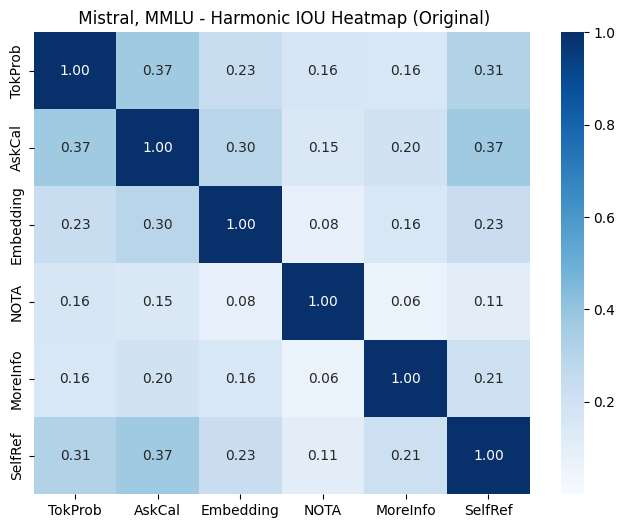

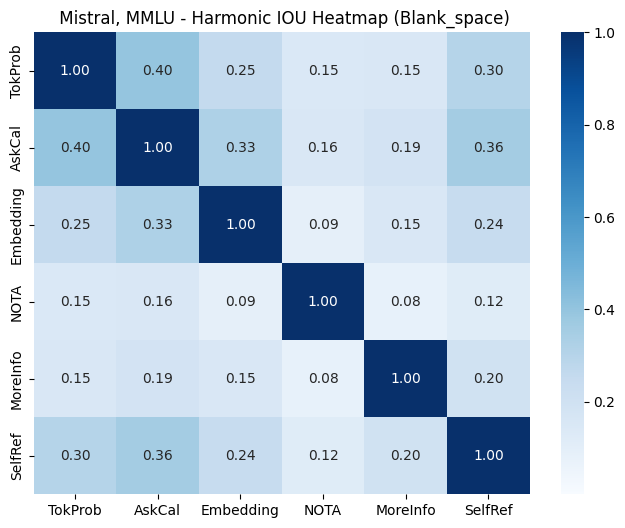

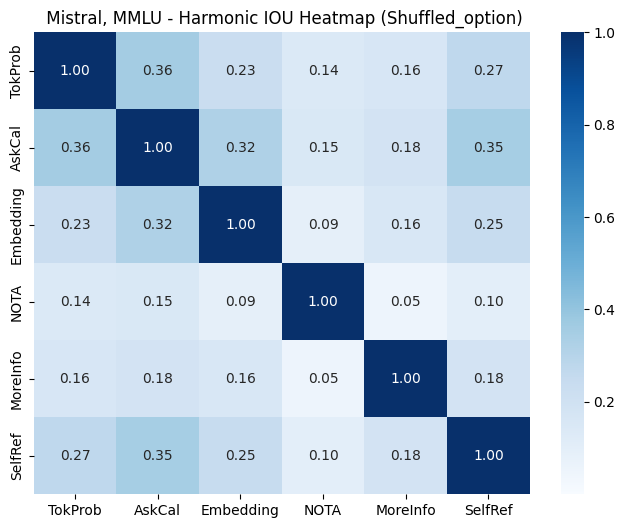

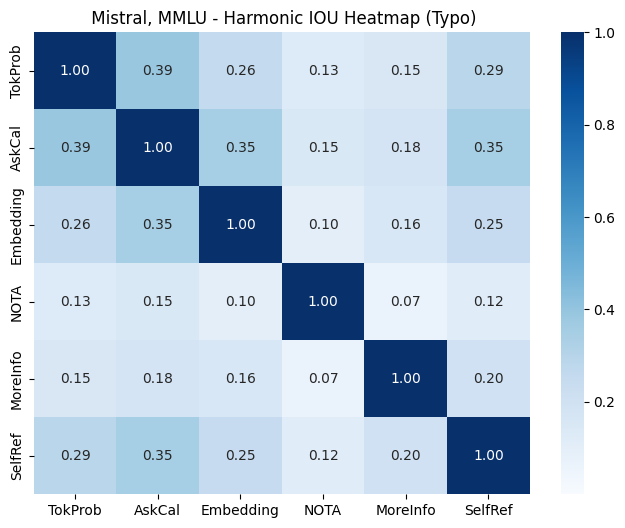

In [ ]:
#harmonic heatmap
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Function to calculate IOU
def calculate_iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Function to calculate Harmonic Mean of IOUs
def harmonic_mean(iou1, iou2):
    return (2 * iou1 * iou2) / (iou1 + iou2) if (iou1 + iou2) > 0 else 0

# Function to calculate the Harmonic IOU
def calculate_harmonic_iou(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0

    set1_accept = {q for q, d in flags1.items() if d == 0}  # Accepted questions in flags1
    set1_reject = {q for q, d in flags1.items() if d == 1}  # Rejected questions in flags1
    set2_accept = {q for q, d in flags2.items() if d == 0}  # Accepted questions in flags2
    set2_reject = {q for q, d in flags2.items() if d == 1}  # Rejected questions in flags2

    # Calculate IOUs for accept and reject sets
    iou_accept = calculate_iou(set1_accept, set2_accept)
    iou_reject = calculate_iou(set1_reject, set2_reject)

    # Calculate Harmonic Mean of IOUs
    return harmonic_mean(iou_accept, iou_reject)

# Function to process JSON files for a specific method and subdirectory
def process_json_files_for_method(directory, subdirectory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method
    subdirectory_path = os.path.join(directory, subdirectory)

    # Process JSON files
    for filename in os.listdir(subdirectory_path):
        if model_name in filename and method in filename and filename.endswith('.json') and "setup_0" in filename:
            file_path = os.path.join(subdirectory_path, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)

    return flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# Main script parameters
methods = ['token', 'calibration', 'embedding', 'nota', 'moreinfo', 'reflect']
display_methods = ['TokProb', 'AskCal', 'Embedding', 'NOTA', 'MoreInfo', 'SelfRef']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_mmlu"
variant_groups = {
    "original": [f"mistraljson_variant"],
    "blank_space": [f"mistraljson_variant", f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    "shuffled_option": [f"mistraljson_variant", f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    "typo": [f"mistraljson_variant", f"{dataset}_typo_1", f"{dataset}_typo_2"],
}

# Process each variant group
for group_name, subdirectories in variant_groups.items():
    print(f"Processing variant group: {group_name}")
    
    # Initialize matrix to accumulate values across setups
    n_methods = len(methods)
    avg_matrix_per_setup = np.zeros((n_methods, n_methods, 5))  # 5 setups, n_methods x n_methods for each setup

    for subdirectory in subdirectories:
        flags_per_method = defaultdict(dict)  # Store flags per method for each subdirectory

        # Process all methods for the current subdirectory
        for method in methods:
            flags_per_method[method] = process_json_files_for_method(directory, subdirectory, model_name, method)

        # Compute pairwise Harmonic IOU for all setups
        for setup_index in range(5):  # Setup indices from 0 to 4
            for i in range(n_methods):
                method_i = methods[i]
                flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
                
                for j in range(i, n_methods):
                    method_j = methods[j]
                    flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
                    
                    # Calculate the Harmonic IOU
                    if i == j:
                        harmonic_iou = 1  # Diagonal value
                    else:
                        harmonic_iou = calculate_harmonic_iou(flags_i, flags_j)

                    # Accumulate values
                    avg_matrix_per_setup[i, j, setup_index] += harmonic_iou
                    if i != j:
                        avg_matrix_per_setup[j, i, setup_index] += harmonic_iou  # Symmetric matrix

    # Average across subdirectories
    avg_matrix_per_setup /= len(subdirectories)

    # Plot the heatmap for each setup
    for setup_index in range(1):
        plt.figure(figsize=(8, 6))
        if "llama" in dataset:
        #sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" LLaMA3, MMLU - Harmonic IOU Heatmap ({group_name.capitalize()})")
                plt.savefig(f"h_llama_mmlu{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" LLaMA3, Hellaswag - Harmonic IOU Heatmap ({group_name.capitalize()})")
                plt.savefig(f"h_llama_hellaswag{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')


        else:
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f", vmin=0, vmax=1,  cbar_kws={'ticks': [1.0, 0.8, 0.6, 0.4, 0.2]})
                plt.title(f" Mistral, MMLU - Harmonic IOU Heatmap ({group_name.capitalize()})")
                plt.savefig(f"h_mistral_mmlu{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" Mistral, Hellaswag - Harmonic IOU Heatmap ({group_name.capitalize()})")
                plt.savefig(f"h_mistral_hellaswag{group_name.capitalize()}.pdf", format='pdf', bbox_inches='tight')
        # sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
        # plt.title(f"Harmonic IOU Heatmap ({group_name.capitalize()})")
        # plt.xlabel("Methods")
        # plt.ylabel("Methods")
        # plt.tight_layout()
        # plt.savefig(f"{model_name}_{group_name}_harmonic_iou.pdf", format='pdf', bbox_inches='tight')
        # plt.show()


In [ ]:
#harmonic shot
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Function to calculate IOU
def calculate_iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Function to calculate Harmonic Mean of IOUs
def harmonic_mean(iou1, iou2):
    return (2 * iou1 * iou2) / (iou1 + iou2) if (iou1 + iou2) > 0 else 0

# Function to calculate the Harmonic IOU
def calculate_harmonic_iou(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0

    set1_accept = {q for q, d in flags1.items() if d == 0}  # Accepted questions in flags1
    set1_reject = {q for q, d in flags1.items() if d == 1}  # Rejected questions in flags1
    set2_accept = {q for q, d in flags2.items() if d == 0}  # Accepted questions in flags2
    set2_reject = {q for q, d in flags2.items() if d == 1}  # Rejected questions in flags2

    # Calculate IOUs for accept and reject sets
    iou_accept = calculate_iou(set1_accept, set2_accept)
    iou_reject = calculate_iou(set1_reject, set2_reject)

    # Calculate Harmonic Mean of IOUs
    return harmonic_mean(iou_accept, iou_reject)

# Function to process JSON files for a specific method and subdirectory
def process_json_files_for_method(directory, subdirectory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method
    subdirectory_path = os.path.join(directory, subdirectory)

    # Process JSON files
    for filename in os.listdir(subdirectory_path):
        if model_name in filename and method in filename and filename.endswith('.json') :#and "setup_0" in filename
            file_path = os.path.join(subdirectory_path, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)
            print(file_path)

    return flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# Main script parameters
methods = ['token', 'calibration', 'embedding', 'nota', 'moreinfo', 'reflect']
display_methods = ['TokProb', 'AskCal', 'Embedding', 'NOTA', 'MoreInfo', 'SelfRef']
model_name = "mistral"
directory = "anonymous_path"
dataset = "mistral_mmlu"
variant_groups = {
    # "original": [f"mistraljson_variant"],
    # "blank_space": [f"mistraljson_variant", f"{dataset}_blank_space_1", f"{dataset}_blank_space_2"],
    # "shuffled_option": [f"mistraljson_variant", f"{dataset}_shuffled_option_1", f"{dataset}_shuffled_option_2"],
    # "typo": [f"mistraljson_variant", f"{dataset}_typo_1", f"{dataset}_typo_2"],
    f"{model_name}": ["mistraljson_oneshot"]
}

# Process each variant group
for group_name, subdirectories in variant_groups.items():
    print(f"Processing variant group: {group_name}")
    
    # Initialize matrix to accumulate values across setups
    n_methods = len(methods)
    avg_matrix_per_setup = np.zeros((n_methods, n_methods, 5))  # 5 setups, n_methods x n_methods for each setup

    for subdirectory in subdirectories:
        flags_per_method = defaultdict(dict)  # Store flags per method for each subdirectory

        # Process all methods for the current subdirectory
        for method in methods:
            flags_per_method[method] = process_json_files_for_method(directory, subdirectory, model_name, method)

        # Compute pairwise Harmonic IOU for all setups
        for setup_index in range(5):  # Setup indices from 0 to 4
            for i in range(n_methods):
                method_i = methods[i]
                flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
                
                for j in range(i, n_methods):
                    method_j = methods[j]
                    flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
                    
                    # Calculate the Harmonic IOU
                    if i == j:
                        harmonic_iou = 1  # Diagonal value
                    else:
                        harmonic_iou = calculate_harmonic_iou(flags_i, flags_j)

                    # Accumulate values
                    avg_matrix_per_setup[i, j, setup_index] += harmonic_iou
                    if i != j:
                        avg_matrix_per_setup[j, i, setup_index] += harmonic_iou  # Symmetric matrix

    # Average across subdirectories
    avg_matrix_per_setup /= len(subdirectories)

    # Plot the heatmap for each setup
    for setup_index in range(1):
        plt.figure(figsize=(8, 6))
        if "llama" in dataset:
        #sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" LLaMA3, MMLU - Harmonic IOU Heatmap (One-shot)")
                plt.savefig(f"h_llama_mmlu_shot.pdf", format='pdf', bbox_inches='tight')
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" LLaMA3, Hellaswag - Harmonic IOU Heatmap (One-shot)")
                plt.savefig(f"h_llama_hellaswag_shot.pdf", format='pdf', bbox_inches='tight')


        else:
            if "mmlu" in dataset:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" Mistral, MMLU - Harmonic IOU Heatmap (One-shot)")
                plt.savefig(f"h_mistral_mmlu_shot.pdf", format='pdf', bbox_inches='tight')
                print("i")
            else:
                sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=display_methods, yticklabels=display_methods, cmap='Blues', fmt=".2f")
                plt.title(f" Mistral, Hellaswag - Harmonic IOU Heatmap (One-shot)")
                plt.savefig(f"h_mistral_hellaswag_shot.pdf", format='pdf', bbox_inches='tight')
        # sns.heatmap(avg_matrix_per_setup[:, :, setup_index], annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues', fmt=".2f")
        # plt.title(f"Harmonic IOU Heatmap ({group_name.capitalize()})")
        # plt.xlabel("Methods")
        # plt.ylabel("Methods")
        # plt.tight_layout()
        # plt.savefig(f"{model_name}_{group_name}_harmonic_iou.pdf", format='pdf', bbox_inches='tight')
        # plt.show()


## Average Heatmap

In [ ]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize variables to hold data
flags_per_method = defaultdict(dict)  # Store flags (abstain or answer) for each method by setup index

# Define function to calculate the ratio of common flags (both abstain or both answer)
def calculate_common_flag_ratio(flags1, flags2):
    if not flags1 or not flags2:  # If one of the flag sets is empty, return 0
        return 0
    
    total_questions = len(flags1)
    same_flags_count = sum(1 for q in flags1 if flags1[q] == flags2.get(q, None))

    return same_flags_count / total_questions if total_questions > 0 else 0

# Define function to process JSON files for a specific method and model
def process_json_files_for_method(directory, model_name, method):
    flags = defaultdict(dict)  # Flags (abstain/answer) per question for a specific method

    # Process JSON files
    for filename in os.listdir(directory):
        if model_name in filename and method in filename and filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            eval_index = int(filename.split('_')[-1].split('.')[0])  # Extract setup index (0-4)
            process_json_file(file_path, eval_index, flags)
            print(file_path)

    # Store the flags for the current method
    flags_per_method[method] = flags

# Function to process each JSON file and extract relevant flags
def process_json_file(file_path, eval_index, flags):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for entry in data:
            question_idx = entry['question_idx']
            decision = entry['decision']  # Either 'abstain' or 'answer'

            # Collect flags for all questions (both abstain and answer)
            flags[eval_index][question_idx] = decision

# List of methods to process
methods = ['calibration', 'embedding', 'nota', 'moreinfo', 'token', 'reflect']
model_name = "llama3"

directory = "anonymous_path"
# Loop over each method and process corresponding JSON files for the Mistral model
for method in methods:
    process_json_files_for_method(directory, model_name, method)

# Initialize matrices to accumulate sums of common flag ratios
n_methods = len(methods)
all_setups_matrix = np.zeros((n_methods, n_methods))  # For setups 0 to 4
setup_1_to_4_matrix = np.zeros((n_methods, n_methods))  # For setups 1 to 4
count_1_to_4 = 0  # To count the number of setups (1 to 4)

# Loop over each setup index (0 to 4) and accumulate common flag ratios
for setup_index in range(5,9):  # Setup indices from 0 to 4
    # Initialize matrix to hold common flag ratios for this setup
    common_flag_matrix = np.zeros((n_methods, n_methods))

    # Calculate pairwise common flag ratios for the same setup across methods
    for i in range(n_methods):
        method_i = methods[i]
        flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
        
        for j in range(i, n_methods):
            method_j = methods[j]
            flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
            
            # If comparing the method with itself, set the diagonal value to 1
            if i == j:
                common_flag_matrix[i, j] = 1
            else:
                # Calculate the common flag ratio for different methods
                common_flag_ratio = calculate_common_flag_ratio(flags_i, flags_j)
                common_flag_matrix[i, j] = common_flag_ratio
                common_flag_matrix[j, i] = common_flag_ratio  # Symmetric matrix

    # Accumulate the matrix for all setups
    all_setups_matrix += common_flag_matrix

    # If setup index is 1 to 4, accumulate for setups 1 to 4
    if setup_index <= 8:
        setup_1_to_4_matrix += common_flag_matrix
        count_1_to_4 += 1

# Average the matrix for all setups (0 to 4)
all_setups_average = all_setups_matrix / 5  # We have 5 setups (0 to 4)

# Average the matrix for setups 1 to 4
setup_1_to_4_average = setup_1_to_4_matrix / count_1_to_4  # We accumulated setups 1 to 4

if model_name =='mistral_mmlu':
    title = 'Mistral'
else:
    title = 'Llama'
# Plotting the heatmap for the average common flag ratio (all setups)
plt.figure(figsize=(8, 6))
sns.heatmap(all_setups_average, annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues')
plt.title(f'{title} Average Common Flag Ratio Heatmap (All setups)')
plt.show()

# Plotting the heatmap for the average common flag ratio (setups 1 to 4)
plt.figure(figsize=(8, 6))
sns.heatmap(setup_1_to_4_average, annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues')
plt.title(f'LLaMa3, Hellaswag - Common Flag Ratio Heatmap (Oneshot)')
plt.savefig(f"{model_name}_{group_name}_setup_{setup_index}_harmonic_iou.pdf", format='pdf', bbox_inches='tight')
plt.show()


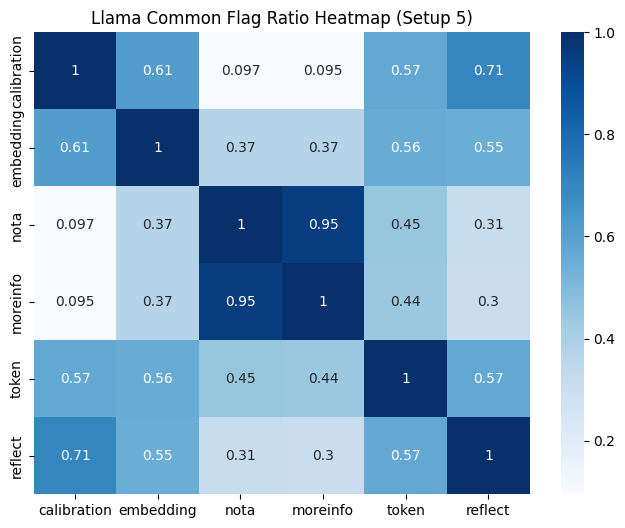

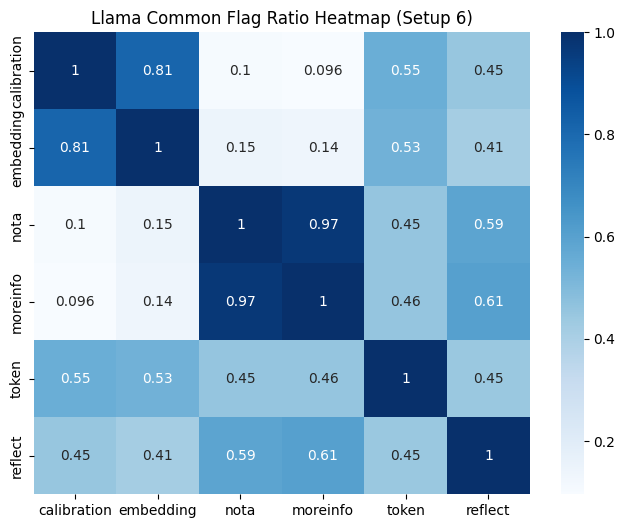

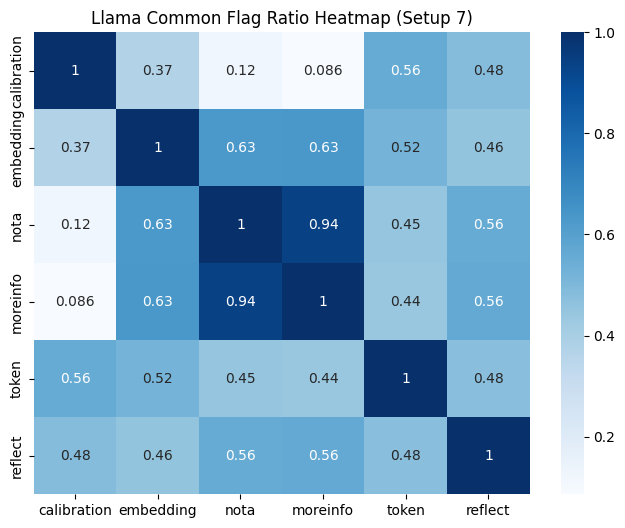

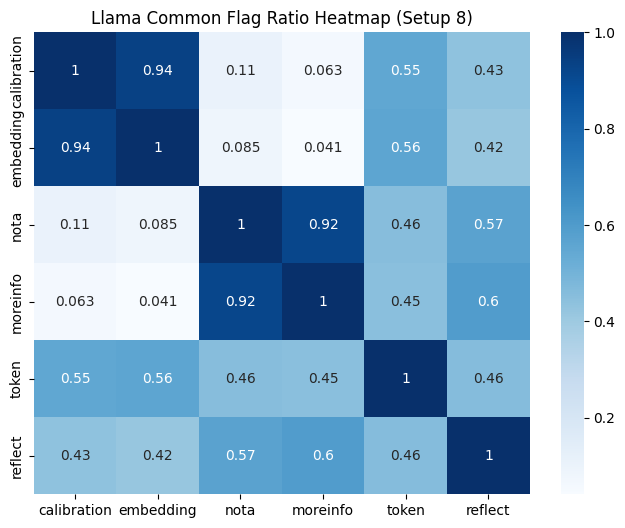

In [66]:
# Loop over each setup index (0 to 4) and plot individual heatmaps
for setup_index in range(5,9):  # Setup indices from 0 to 4
    # Initialize matrix to hold common flag ratios for this setup
    common_flag_matrix = np.zeros((n_methods, n_methods))

    # Calculate pairwise common flag ratios for the same setup across methods
    for i in range(n_methods):
        method_i = methods[i]
        flags_i = flags_per_method[method_i].get(setup_index, {})  # Get flags for method_i
        
        for j in range(i, n_methods):
            method_j = methods[j]
            flags_j = flags_per_method[method_j].get(setup_index, {})  # Get flags for method_j
            
            # If comparing the method with itself, set the diagonal value to 1
            if i == j:
                common_flag_matrix[i, j] = 1
            else:
                # Calculate the common flag ratio for different methods
                common_flag_ratio = calculate_common_flag_ratio(flags_i, flags_j)
                common_flag_matrix[i, j] = common_flag_ratio
                common_flag_matrix[j, i] = common_flag_ratio  # Symmetric matrix

    # Plotting the heatmap for the current setup
    plt.figure(figsize=(8, 6))
    sns.heatmap(common_flag_matrix, annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues')
    plt.title(f'{title} Common Flag Ratio Heatmap (Setup {setup_index})')
    plt.show()
